# Multi-task model

In [80]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import os 
import shutil

import copy

import tensorflow as tf
import tensorflow.keras as K

from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import CCLE_utils
import MMRF_utils

## Load encoded cell line data

In [2]:
with pd.HDFStore('normalized_embeddings.h5') as store:
    print(store.keys())

['/ccle_test_ccleae', '/ccle_test_combinedae', '/ccle_test_mmrfae', '/ccle_train_ccleae', '/ccle_train_combinedae', '/ccle_train_mmrfae', '/ccle_valid_ccleae', '/ccle_valid_combinedae', '/ccle_valid_mmrfae', '/mmrf_test_ccleae', '/mmrf_test_combinedae', '/mmrf_test_mmrfae', '/mmrf_train_ccleae', '/mmrf_train_combinedae', '/mmrf_train_mmrfae', '/mmrf_valid_ccleae', '/mmrf_valid_combinedae', '/mmrf_valid_mmrfae']


In [3]:
X_train = pd.read_hdf("normalized_embeddings.h5", key = 'ccle_train_mmrfae', index_col=1)
X_train = X_train.set_index(X_train.iloc[:, 0])
X_train = X_train.iloc[: , 1:]

X_val = pd.read_hdf("normalized_embeddings.h5", key = 'ccle_valid_mmrfae', index_col=1)
X_val = X_val.set_index(X_val.iloc[:, 0])
X_val = X_val.iloc[: , 1:]

X_test = pd.read_hdf("normalized_embeddings.h5", key = 'ccle_test_mmrfae', index_col=1)
X_test = X_test.set_index(X_test.iloc[:, 0])
X_test = X_test.iloc[: , 1:]

In [4]:
crispr_rnaseq_merged = pd.read_csv('rnaseq_crispr_merged.csv')
crispr_rnaseq_merged = crispr_rnaseq_merged.set_index(['DepMap_ID'])
response_cols = [col for col in crispr_rnaseq_merged.columns if '_y' in col]
crispr = crispr_rnaseq_merged[response_cols]

In [5]:
train_index = list(set(X_train.index).intersection(crispr.index))
val_index = list(set(X_val.index).intersection(crispr.index))
test_index = list(set(X_test.index).intersection(crispr.index))

In [6]:
X_train = X_train.loc[train_index]
Y_train = crispr.loc[train_index]

X_val = X_val.loc[val_index]
Y_val = crispr.loc[val_index]

X_test = X_test.loc[test_index]
Y_test = crispr.loc[test_index]

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(559, 128) (559, 13)
(165, 128) (165, 13)


In [7]:
#binary outcome used for classifier; positive = 1, negative = 0
bY_train = (Y_train >0).astype(int)
bY_val = (Y_val >0).astype(int)
bY_test = (Y_test >0).astype(int)

In [8]:
# onehot encode binary outcomes
bY_train_oneHot = K.utils.to_categorical(bY_train, 2)
bY_val_oneHot = K.utils.to_categorical(bY_val, 2)
bY_test_oneHot = K.utils.to_categorical(bY_test, 2)

print(bY_train_oneHot.shape, bY_val_oneHot.shape, bY_test_oneHot.shape)

(559, 13, 2) (77, 13, 2) (165, 13, 2)


# Load MMRF data

In [72]:
X_train_pt = pd.read_hdf("normalized_embeddings.h5", key = 'mmrf_train_mmrfae', index_col=1)
X_train_pt = X_train_pt.set_index(X_train_pt.iloc[:, 0])
X_train_pt = X_train_pt.iloc[: , 1:]

X_val_pt = pd.read_hdf("normalized_embeddings.h5", key = 'mmrf_valid_mmrfae', index_col=1)
X_val_pt = X_val_pt.set_index(X_val_pt.iloc[:, 0])
X_val_pt = X_val_pt.iloc[: , 1:]

X_test_pt = pd.read_hdf("normalized_embeddings.h5", key = 'mmrf_test_mmrfae', index_col=1)
X_test_pt = X_test_pt.set_index(X_test_pt.iloc[:, 0])
X_test_pt = X_test_pt.iloc[: , 1:]

In [87]:
train_patient_all = pd.DataFrame()
valid_patient_all = pd.DataFrame()
test_patient_all = pd.DataFrame()

for ind in [1]:
    data_filename = './data/cleaned_mm%d_2mos_pfs_ind.pkl'%(ind)
    train, test, valid = MMRF_utils.get_train_test_valid(data_filename, ind, show_features=True)

    print('\nPreprocess patient data in MMRF')
    # include the first n clinical visit data for each patient (default 0)
    train_df = MMRF_utils.preprocess_patient_data(train, num_clin_visits=3)  
    print(train_df.shape)

    valid_df = MMRF_utils.preprocess_patient_data(valid, num_clin_visits=3)  
    print(valid_df.shape)

    test_df = MMRF_utils.preprocess_patient_data(test, num_clin_visits=3)  
    print(test_df.shape)

    print('\nPreprocess patient genomic data in MMRF...')
    genomic_fn = './data/MMRF_CoMMpass_IA15a_E74GTF_Salmon_Gene_TPM.txt'
    genomic_df = MMRF_utils.preprocess_genomic_data(genomic_fn, nPCA=0)
    print(genomic_df.shape)

    print('\nMerging patient data with genomic data...')
    train_patient_all = train_patient_all.append(train_df.merge(genomic_df, left_on='pids', right_on='pids'))

    valid_patient_all = valid_patient_all.append(valid_df.merge(genomic_df, left_on='pids', right_on='pids'))

    test_patient_all = test_patient_all.append(test_df.merge(genomic_df, left_on='pids', right_on='pids'))

loading from: ./data/cleaned_mm1_2mos_pfs_ind.pkl
pids
(494,)
x
(494, 33, 16)
m
(494, 33, 16)
feature_names_x
(16,)
['cbc_abs_neut' 'chem_albumin' 'chem_bun' 'chem_calcium' 'chem_creatinine'
 'chem_glucose' 'cbc_hemoglobin' 'serum_kappa' 'serum_m_protein'
 'cbc_platelet' 'chem_totprot' 'cbc_wbc' 'serum_iga' 'serum_igg'
 'serum_igm' 'serum_lambda']
ys_seq
(494, 1)
ce
(494, 1)
feature_names_y
(1,)
['progression free survival (all)']
b
(494, 16)
feature_names
(16,)
Index(['iss', 'age', 'gender', 'ecog', 'serum_beta2_microglobulin', 'PC1',
       'PC2', 'PC3', 'PC4', 'PC5', 'heavy_chain', 'igg_type', 'iga_type',
       'igm_type', 'kappa_type', 'lambda_type'],
      dtype='object')
a
(494, 33, 9)
m_a
(494, 33, 6)
feature_names_a
(9,)
['local_clock' 'Bor' 'Car' 'Cyc' 'Dex' 'Len' 'line1' 'line2' 'line3plus']

Preprocess patient data in MMRF
Keep first 3 clinical visits.
(461, 93)
Keep first 3 clinical visits.
(161, 93)
Keep first 3 clinical visits.
(214, 93)

Preprocess patient genomic data 

In [93]:
train_pfs = train_patient_all[['pids','pfs']]
train_pfs = train_pfs.set_index('pids')

val_pfs = valid_patient_all[['pids','pfs']]
val_pfs = val_pfs.set_index('pids')

test_pfs = test_patient_all[['pids','pfs']]
test_pfs = test_pfs.set_index('pids')

In [100]:
train_index_pt = list(set(X_train_pt.index).intersection(train_pfs.index))
val_index_pt = list(set(X_val_pt.index).intersection(val_pfs.index))
test_index_pt = list(set(X_test_pt.index).intersection(test_pfs.index))

In [103]:
X_train_pt = X_train_pt.loc[train_index_pt]
Y_train_pfs = train_pfs.loc[train_index_pt]

X_val_pt = X_val_pt.loc[val_index_pt]
Y_val_pfs = val_pfs.loc[val_index_pt]

X_test_pt = X_test_pt.loc[test_index_pt]
Y_test_pfs = test_pfs.loc[test_index_pt]

In [104]:
print(X_train_pt.shape, Y_train_pfs.shape)
print(X_test_pt.shape, Y_test_pfs.shape)

(313, 128) (313, 1)
(142, 128) (142, 1)


In [107]:
bY_train_pfs = (Y_train_pfs >12).astype(int)
bY_val_pfs = (Y_val_pfs >12).astype(int)
bY_test_pfs = (Y_test_pfs >12).astype(int)

In [108]:
# onehot encode binary outcomes
bY_train_pfs_oneHot = K.utils.to_categorical(bY_train_pfs, 2)
bY_val_pfs_oneHot = K.utils.to_categorical(bY_val_pfs, 2)
bY_test_pfs_oneHot = K.utils.to_categorical(bY_test_pfs, 2)

print(bY_train_pfs_oneHot.shape, bY_val_pfs_oneHot.shape, bY_test_pfs_oneHot.shape)

(313, 2) (97, 2) (142, 2)


# EDA 

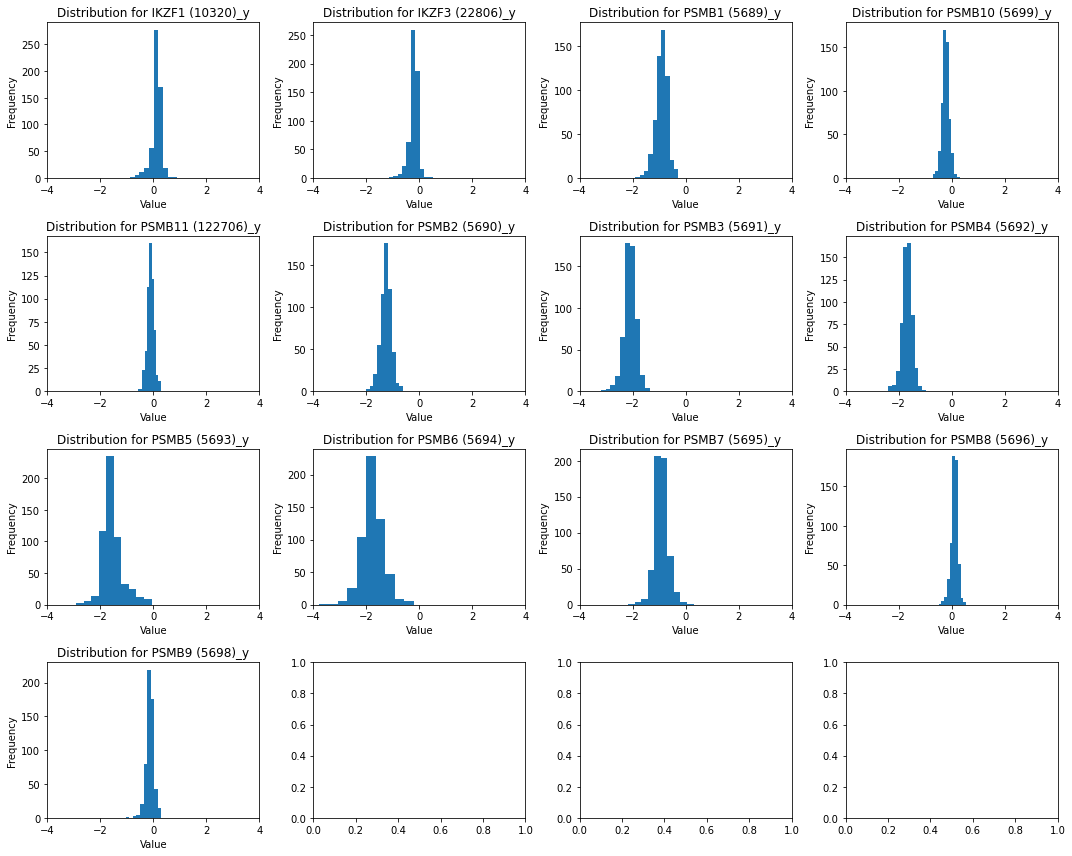

In [67]:
fig, ax = plt.subplots(4, 4, figsize = (15,12))


ax_new = Y_train.hist(bins=10, ax=ax.ravel()[:13])
for i in range(13):
    ax_new[i].set_xlabel("Value")
    ax_new[i].set_ylabel("Frequency") 
    ax_new[i].set_title(f"Distribution for {Y_train.columns[i]}")
#     boundary = max(np.ceil(abs(Y_train[Y_train.columns[i]].min())),np.ceil(abs(Y_train[Y_train.columns[i]].max())))
    ax_new[i].set_xlim(-1*4,4)
    ax_new[i].grid(False)

plt.tight_layout()

# Define models

In [9]:
def generate_classifier(N_in):
    inputs = K.layers.Input(shape = (N_in,))
    x = K.layers.Dense(64, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.01))(inputs)
    x = K.layers.Dense(32, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.01))(x)   
    y1 = K.layers.Dense(2, activation='softmax', kernel_regularizer=K.regularizers.l2(l=0.01), name='y1')(x)
    y2 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y2')(x)
    y3 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y3')(x)
    y4 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y4')(x)
    y5 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y5')(x)
    y6 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y6')(x)
    y7 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y7')(x)
    y8 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y8')(x)
    y9 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y9')(x)
    y10 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y10')(x)
    y11 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y11')(x)
    y12 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y12')(x)
    y13 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y13')(x)
    
    combined = [y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13]
    tensors = [tf.expand_dims(i, axis=1) for i in combined]
    output = K.layers.concatenate(tensors, axis=1)
    
    model = K.models.Model(inputs = inputs, outputs = output)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [10]:
def generate_regressor(N_in):
    inputs = K.layers.Input(shape = (N_in,))
    x = K.layers.Dense(64, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.01))(inputs)
    x = K.layers.Dense(32, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.01))(x)
    y1 = K.layers.Dense(1, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.01), name='y1')(x)
    y2 = K.layers.Dense(1, activation='relu',kernel_regularizer=K.regularizers.l2(l=0.01), name='y2')(x)
    y3 = K.layers.Dense(1, activation='relu',kernel_regularizer=K.regularizers.l2(l=0.01), name='y3')(x)
    y4 = K.layers.Dense(1, activation='relu',kernel_regularizer=K.regularizers.l2(l=0.01), name='y4')(x)
    y5 = K.layers.Dense(1, activation='relu',kernel_regularizer=K.regularizers.l2(l=0.01), name='y5')(x)
    y6 = K.layers.Dense(1, activation='relu',kernel_regularizer=K.regularizers.l2(l=0.01), name='y6')(x)
    y7 = K.layers.Dense(1, activation='relu',kernel_regularizer=K.regularizers.l2(l=0.01), name='y7')(x)
    y8 = K.layers.Dense(1, activation='relu',kernel_regularizer=K.regularizers.l2(l=0.01), name='y8')(x)
    y9 = K.layers.Dense(1, activation='relu',kernel_regularizer=K.regularizers.l2(l=0.01), name='y9')(x)
    y10 = K.layers.Dense(1, activation='relu',kernel_regularizer=K.regularizers.l2(l=0.01), name='y10')(x)
    y11 = K.layers.Dense(1, activation='relu',kernel_regularizer=K.regularizers.l2(l=0.01), name='y11')(x)
    y12 = K.layers.Dense(1, activation='relu',kernel_regularizer=K.regularizers.l2(l=0.01), name='y12')(x)
    y13 = K.layers.Dense(1, activation='relu',kernel_regularizer=K.regularizers.l2(l=0.01), name='y13')(x)
    
    model = K.models.Model(inputs = inputs, outputs = [y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13])
    model.compile(optimizer='adam',
                  loss=generate_loss(13, 'mse'))
    
    return model

In [11]:
def generate_loss(N_out, loss):
    L = dict()
    for i in range(1, N_out+1):
        k = 'y'+str(i)
        L[k] = loss
    return L

In [12]:
def plot_pred(y_train, y_train_pred, y_test, y_test_pred, i):

    fig, ax = plt.subplots(1,1)

    ax.scatter(y_train[:,i],y_train_pred[i,:,0], label='Train', color='#4287f5')
    ax.scatter(y_test[:,i],y_test_pred[i,:,0], label='Test', color='#f2797f')
    # ax.set_xlim(-4,2)
    # ax.set_ylim(-4,2)
    ax.set_xlabel('True Response')
    ax.set_ylabel('Predicted Response')
    ax.legend()
    ax.set_title('CRISPR Knockout Experiment '+str(i))

In [13]:
def plot_loss(perf_dict):
    fig = plt.figure(figsize=(15,10))
    ax1 = plt.subplot(2,2,1)
    ax2 = plt.subplot(2,2,2)
    loss = perf_dict['loss']
    val_loss = perf_dict['val_loss']
    ax1.plot(loss)
    ax2.plot(val_loss)
    ax1.set_xlabel('epochs')
    ax2.set_xlabel('epochs')

    ax1.set_ylabel('loss')
    ax2.set_ylabel('val_loss')
    plt.show()

# Train Classifier Model

In [34]:
classifier = generate_classifier(X_train.shape[1])
classifier.summary()

print("Input", classifier.input_shape)
print("Output", classifier.output_shape)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 32)           2080        dense_2[0][0]                    
__________________________________________________________________________________________________
y1 (Dense)                      (None, 2)            66          dense_3[0][0]                    
____________________________________________________________________________________________

In [15]:
classifier_history = classifier.fit(X_train,bY_train_oneHot,epochs=100, validation_data=(X_val, bY_val_oneHot),verbose=0)

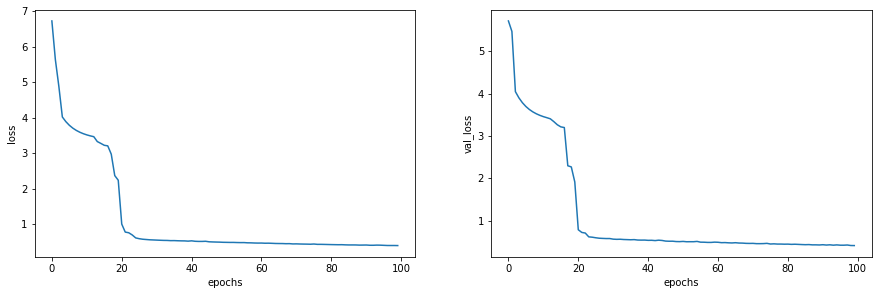

In [16]:
plot_loss(classifier_history.history)

In [17]:
y_train_classifierPred = np.array(classifier.predict(X_train))[:,:,1]
y_test_classifierPred = np.array(classifier.predict(X_test))[:,:,1]

bY_test_true = bY_test_oneHot[:,:,1]
bY_train_true = bY_train_oneHot[:,:,1]

print(y_train_classifierPred.shape, y_test_classifierPred.shape)
print(bY_train_true.shape, bY_test_true.shape)

(559, 13) (165, 13)
(559, 13) (165, 13)


In [18]:
n_classes = 13
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(bY_test_true[:, i], y_test_classifierPred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(bY_test_true.ravel(), y_test_classifierPred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/Users/eshikasaxena/miniconda3/envs/cs109b/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/Users/eshikasaxena/miniconda3/envs/cs109b/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/Users/eshikasaxena/miniconda3/envs/cs109b/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/Users/eshikasaxena/miniconda3/envs/cs109b/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true

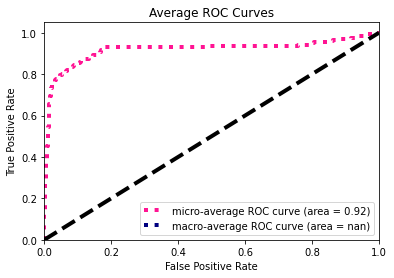

In [19]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average ROC Curves')
plt.legend(loc="lower right")
plt.show()

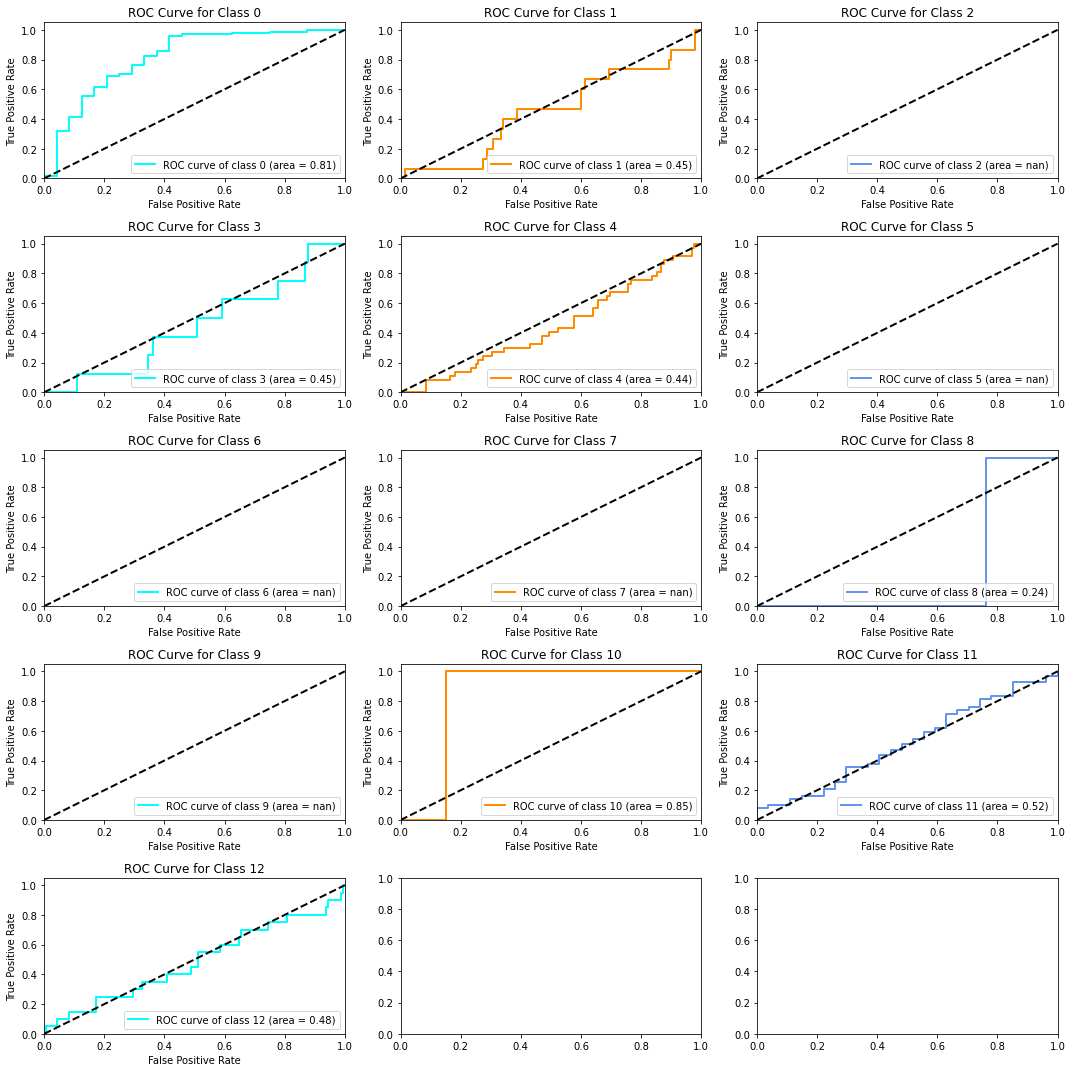

In [20]:
fig, axes = plt.subplots(5, 3, figsize=(15,15))
lw = 2

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, ax, color in zip(range(13), axes.ravel(), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for Class {i}')
    ax.legend(loc="lower right")

plt.tight_layout()

# Train Regression Model

In [45]:
## regressor

regressor = generate_regressor(X_train.shape[1])
regressor.summary()

print("Input", regressor.input_shape, "Output", regressor.output_shape)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 32)           4128        input_6[0][0]                    
__________________________________________________________________________________________________
y1 (Dense)                      (None, 1)            33          dense_5[0][0]                    
__________________________________________________________________________________________________
y2 (Dense)                      (None, 1)            33          dense_5[0][0]                    
____________________________________________________________________________________________

In [95]:
regressor_history = regressor.fit(X_train,Y_train,epochs=10000,batch_size=128,  validation_data=(X_val, Y_val),verbose=0)

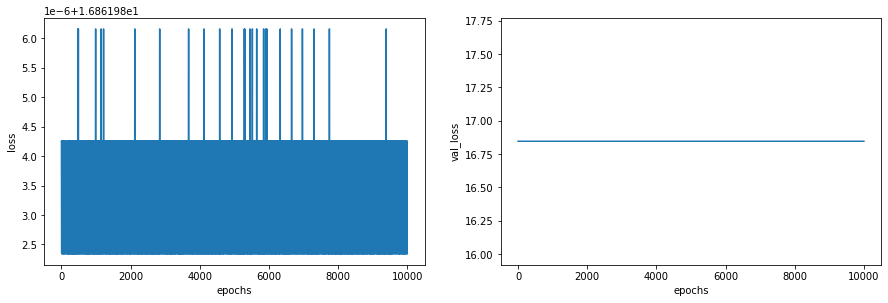

In [96]:
plot_loss(regressor_history.history)

In [97]:
y_train_regressorPred = np.array(regressor.predict(X_train))
y_test_regressorPred = np.array(regressor.predict(X_test))

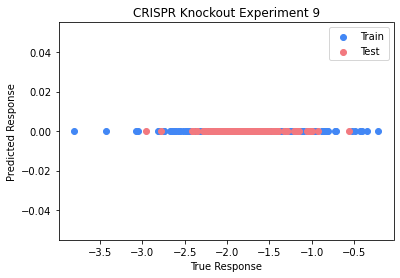

In [98]:
plot_pred(np.array(Y_train), y_train_regressorPred, np.array(Y_test), y_test_regressorPred, 9)

# Feature transfer patient data
Freeze network except the last layer, then train on patient data

In [33]:
classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           8256        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           2080        dense[0][0]                      
__________________________________________________________________________________________________
y1 (Dense)                      (None, 2)            66          dense_1[0][0]                    
______________________________________________________________________________________________

In [112]:
classifier.layers[0].trainable = False
classifier.layers[1].trainable = False
classifier.layers[2].trainable = False

transfer = classifier.layers[2].output

final_output = K.layers.Dense(2, activation='softmax', kernel_regularizer=K.regularizers.l2(l=0.01), name='final')(transfer)

transfer_model = K.models.Model(inputs=classifier.input, outputs=final_output)

transfer_model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])

print(classifier.summary())
print(transfer_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 32)           2080        dense_2[0][0]                    
__________________________________________________________________________________________________
y1 (Dense)                      (None, 2)            66          dense_3[0][0]                    
____________________________________________________________________________________________

In [113]:
history_pt = transfer_model.fit(X_train_pt, bY_train_pfs_oneHot, epochs=100, validation_data=(X_val_pt, bY_val_pfs_oneHot))

Epoch 1/100
10/10 [==============================] - 2s 48ms/step - loss: 9.1301 - accuracy: 0.4597 - val_loss: 5.7265 - val_accuracy: 0.3608
Epoch 2/100
10/10 [==============================] - 0s 8ms/step - loss: 9.4499 - accuracy: 0.4235 - val_loss: 5.5312 - val_accuracy: 0.3608
Epoch 3/100
10/10 [==============================] - 0s 6ms/step - loss: 8.6328 - accuracy: 0.4932 - val_loss: 5.3434 - val_accuracy: 0.3711
Epoch 4/100
10/10 [==============================] - 0s 6ms/step - loss: 7.9122 - accuracy: 0.4452 - val_loss: 5.1247 - val_accuracy: 0.3608
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 7.8557 - accuracy: 0.4902 - val_loss: 4.9130 - val_accuracy: 0.3711
Epoch 6/100
10/10 [==============================] - 0s 6ms/step - loss: 7.5182 - accuracy: 0.4644 - val_loss: 4.7231 - val_accuracy: 0.3918
Epoch 7/100
10/10 [==============================] - 0s 7ms/step - loss: 7.5804 - accuracy: 0.4567 - val_loss: 4.5240 - val_accuracy: 0.3711
Epoch 8/100


10/10 [==============================] - 0s 5ms/step - loss: 2.3335 - accuracy: 0.6332 - val_loss: 2.1251 - val_accuracy: 0.5670
Epoch 59/100
10/10 [==============================] - 0s 6ms/step - loss: 2.2631 - accuracy: 0.6518 - val_loss: 2.1233 - val_accuracy: 0.5876
Epoch 60/100
10/10 [==============================] - 0s 7ms/step - loss: 2.2219 - accuracy: 0.6327 - val_loss: 2.1135 - val_accuracy: 0.5670
Epoch 61/100
10/10 [==============================] - 0s 5ms/step - loss: 2.3493 - accuracy: 0.6041 - val_loss: 2.1088 - val_accuracy: 0.5876
Epoch 62/100
10/10 [==============================] - 0s 6ms/step - loss: 2.3685 - accuracy: 0.6028 - val_loss: 2.1051 - val_accuracy: 0.5876
Epoch 63/100
10/10 [==============================] - 0s 6ms/step - loss: 2.2714 - accuracy: 0.6188 - val_loss: 2.0987 - val_accuracy: 0.5979
Epoch 64/100
10/10 [==============================] - 0s 7ms/step - loss: 2.2487 - accuracy: 0.6283 - val_loss: 2.0982 - val_accuracy: 0.5979
Epoch 65/100
10/10 

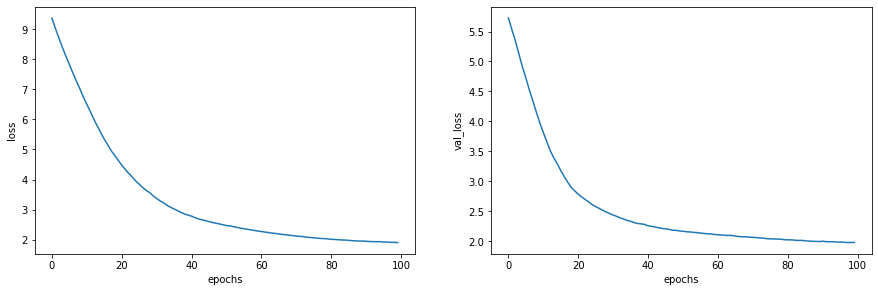

In [114]:
plot_loss(history_pt.history)

In [146]:
y_train_transferPred = np.array(transfer_model.predict(X_train_pt))[:,1]
y_test_transferPred = np.array(transfer_model.predict(X_test_pt))[:,1]

y_train_transferPred = np.where(y_train_transferPred > 0.5, 1, 0)
y_test_transferPred = np.where(y_test_transferPred > 0.5, 1, 0)

bY_train_true_pfs = bY_train_pfs_oneHot[:,1]
bY_test_true_pfs = bY_test_pfs_oneHot[:,1]

print(y_train_transferPred.shape, y_test_transferPred.shape)
print(bY_train_true_pfs.shape, bY_test_true_pfs.shape)

(313,) (142,)
(313,) (142,)


In [147]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def get_stats(true_pfs,pred_pfs):
    metrics = [accuracy_score, precision_score, recall_score, f1_score]
    return([np.round(metric(true_pfs, pred_pfs),2) for metric in metrics])

In [148]:
tr_stats = get_stats(bY_train_true_pfs, y_train_transferPred)
val_stats = get_stats(bY_test_true_pfs, y_test_transferPred)

results_df = (pd.DataFrame({'Experiment': 'CRISPR',
                      'Train Accuracy': tr_stats[0],
                      'Train Precision': tr_stats[1],
                      'Train Recall': tr_stats[2],
                      'Train F1': tr_stats[3],

                      'Val Accuracy': val_stats[0],
                      'Val Precision': val_stats[1],
                      'Val Recall': val_stats[2],
                      'Val F1': val_stats[3]},index=[0]))

display(results_df)

,Experiment,Train Accuracy,Train Precision,Train Recall,Train F1,Val Accuracy,Val Precision,Val Recall,Val F1
0,CRISPR,0.69,0.73,0.86,0.78,0.57,0.59,0.8,0.68


# Save model

In [ ]:
# model = K.models.load_model(model_dir)

In [ ]:
# model_dir = os.path.join('6.871models', 'simpleNN042721')
# shutil.rmtree(model_dir)
# model.save(model_dir)
